In [ ]:
%pip install pandas
%pip install scanpy
%pip install squidpy

In [ ]:
%pip install plotly

In [1]:
import pandas as pd
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')
from anndata import AnnData
import sys
from SpatialCell.plot import stack_plot
import random
random.seed(42)
sys.path.append('SpatialCell/SpatialCell')
import SpatialCell.tool as spct
import SpatialCell.plot as spcp
import squidpy as sq

In [51]:
from matplotlib.pyplot import rc_context
import seaborn as sns
sc.set_figure_params(dpi=100, color_map="viridis_r")
sc.settings.verbosity = 0
sc.logging.print_header()

scanpy==1.10.4 anndata==0.11.3 umap==0.5.7 numpy==2.0.2 scipy==1.15.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


In [57]:
import SpatialCell.tool.neighborhood as spn

In [58]:
import importlib
importlib.reload(spct) 
importlib.reload(spn) 

<module 'SpatialCell.tool.neighborhood' from '/workspaces/spatiocell/SpatialCell/tool/neighborhood.py'>

In [4]:
adata = sc.read_h5ad('SpatialCell/data/codex_mouse_spleen.h5ad')

In [5]:
adata.raw = adata.copy()
for sample in adata.obs['sample'].cat.categories:
    adata.X[adata.obs['sample'] == sample, :] = sc.pp.scale(adata[adata.obs['sample'] == sample], copy=True).X

In [6]:
sc.tl.pca(adata)

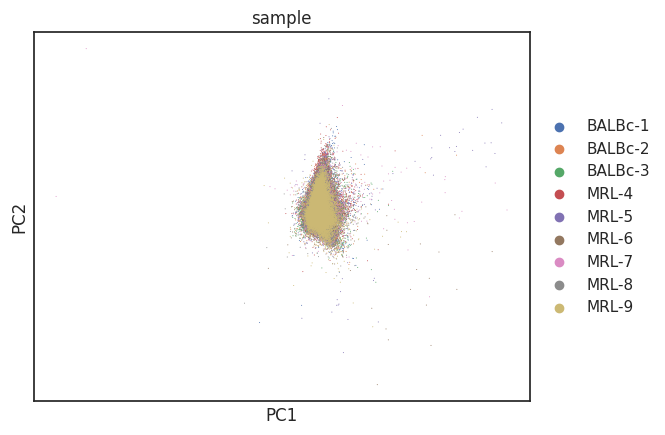

In [7]:
sc.pl.pca(
    adata,
    color=["sample"],
    size=2,
)

In [8]:
adata

AnnData object with n_obs × n_vars = 707474 × 29
    obs: 'cell_type', 'i-niche', 'tile', 'area', 'dataset', 'stage', 'sample'
    uns: 'spatial', 'spatial_cluster_colors', 'pca', 'sample_colors'
    obsm: 'blanks', 'spatial', 'X_pca'
    varm: 'PCs'

In [9]:
sc.tl.rank_genes_groups(adata, groupby="cell_type", method="wilcoxon")

In [10]:
adata.layers["scaled"] = sc.pp.scale(adata, copy=True).X

In [11]:
adata

AnnData object with n_obs × n_vars = 707474 × 29
    obs: 'cell_type', 'i-niche', 'tile', 'area', 'dataset', 'stage', 'sample'
    uns: 'spatial', 'spatial_cluster_colors', 'pca', 'sample_colors', 'rank_genes_groups'
    obsm: 'blanks', 'spatial', 'X_pca'
    varm: 'PCs'
    layers: 'scaled'

In [12]:
subset = adata[adata.obs["sample"] == "BALBc-1"].copy()
pos = subset.obsm['spatial']
labels = subset.obs["cell_type"]
radius = 100000

In [59]:
result = spn.compute_neighborhood_stats(pos, labels)

Using radius of 8592.609509589698


100%|██████████| 82382/82382 [00:00<00:00, 146101.81it/s]


In [60]:
result.index = subset.obs_names
subset.obsm["neighborhood"] = result

In [62]:
result['cell_type'] = labels

In [64]:
sp = pd.DataFrame(subset.obsm['spatial'],columns=['x','y'] , index = subset.obs_names)
sp['cell_type'] = subset.obs['cell_type']   

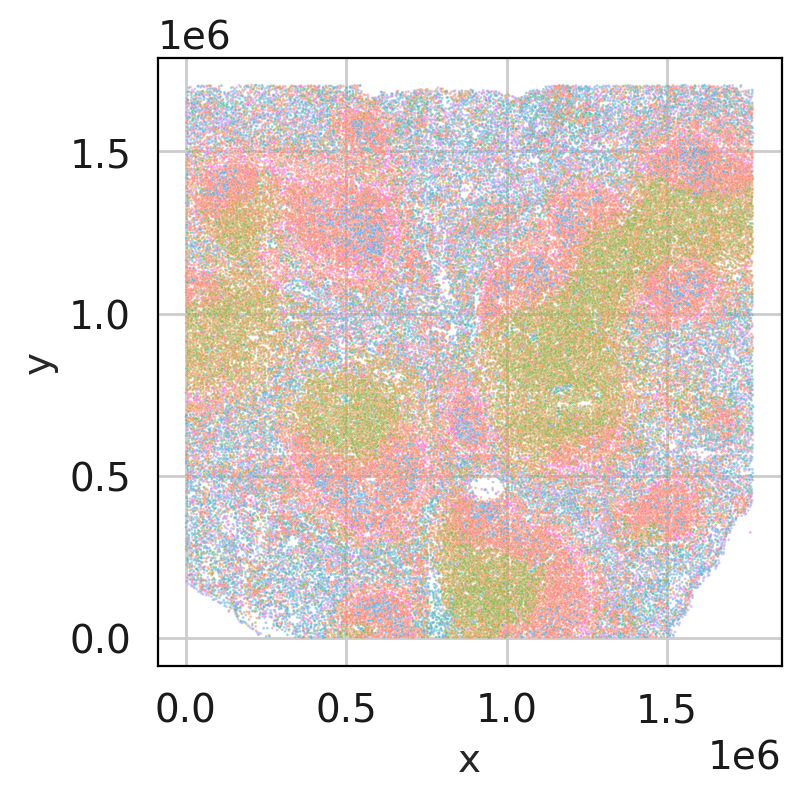

In [65]:
import matplotlib.pyplot as plt
sns.scatterplot(data=sp, x='x', y='y',
                hue ='cell_type' , s = 1, alpha = 0.5 )
plt.legend()
plt.gca().get_legend().set_visible(False)

In [81]:
fig_df = result.groupby('cell_type').mean().reset_index()
fig_df.index = fig_df['cell_type']
fig_df = fig_df.drop('cell_type', axis=1)
fig_df = fig_df.div(fig_df.sum(axis=1), axis=0)

In [79]:
import numpy as np
from scipy.stats import zscore
for i in range(fig_df.shape[1]):
    fig_df.iloc[i,:] = zscore(fig_df.iloc[i,:])
fig_df[np.isinf(fig_df)] = 0

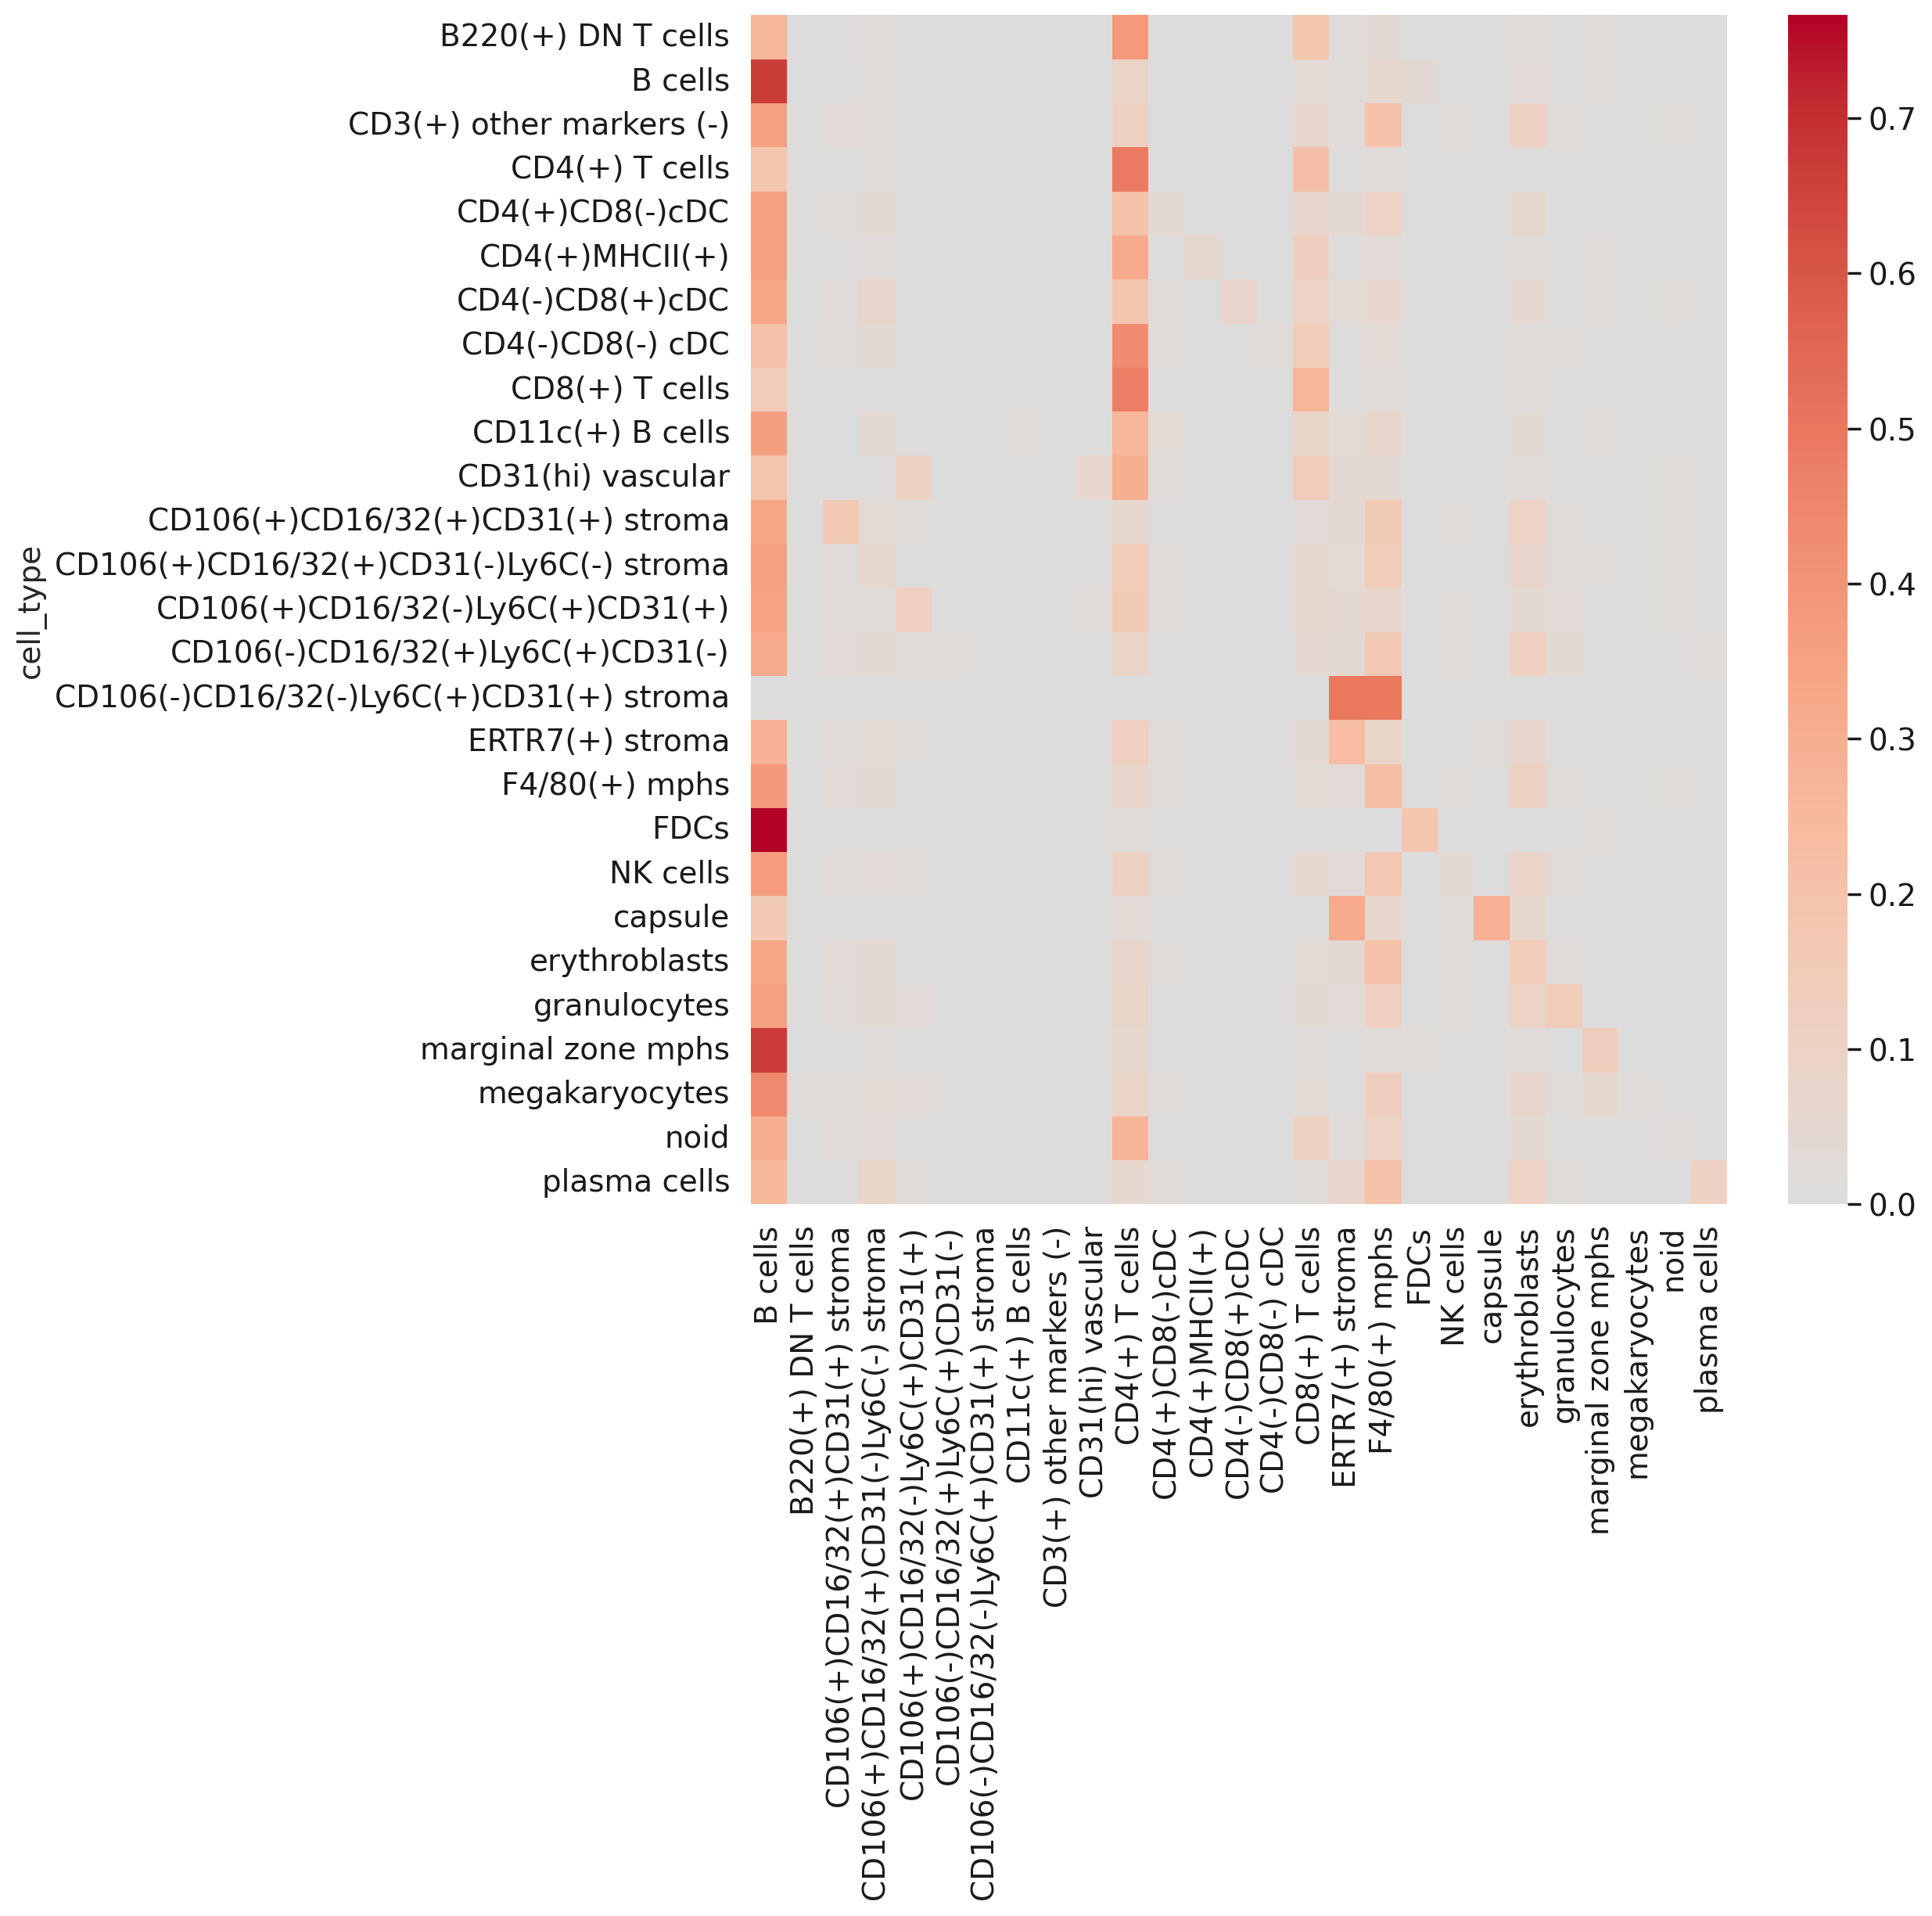

In [82]:
with rc_context({"figure.figsize": (10, 10)}):
    sns.heatmap(data=fig_df , cmap = 'coolwarm' , center = 0)